In [8]:
import pandas as pd
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Cargar dataset
df = pd.read_csv("landmarks_dataset.csv")

# Separar datos y etiquetas
X = df.drop(columns=["label"])
y = df["label"]

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar modelo Random Forest
#rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf = RandomForestClassifier(
    n_estimators=500,  # Más árboles
    max_depth=20,  # Limitar profundidad
    max_features='sqrt',  # Reducir número de características evaluadas por nodo
    random_state=42
)

rf.fit(X_train, y_train)

# Evaluar modelo
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Precisión del modelo: {accuracy:.2%}")

joblib.dump(rf, "modelo_random_forest.pkl")
print("💾 Modelo guardado como modelo_random_forest.pkl")

✅ Precisión del modelo: 67.36%
💾 Modelo guardado como modelo_random_forest.pkl


C:\Users\angel\miniconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


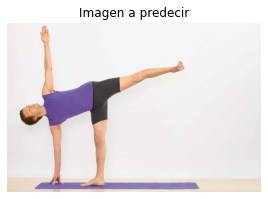

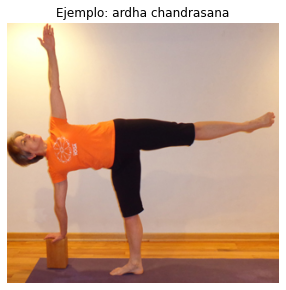

📸 Pose predicha: ardha chandrasana


In [31]:
import cv2
import mediapipe as mp
import numpy as np
import joblib
import os

# Cargar modelo Random Forest
model = joblib.load("modelo_random_forest.pkl")

#Obtener los nombres de las poses (las carpetas del dataset)
dataset_folder = "dataset"
pose_names = os.listdir(dataset_folder)

#Inicializar MediaPipe
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Cargar imagen a predecir
img_path = "fotoDetectar.jpg"  # Cambia esto por tu imagen
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Procesar imagen y extraer landmarks
results = pose.process(image_rgb)

if results.pose_landmarks:
    landmarks = []
    for lm in results.pose_landmarks.landmark:
        landmarks.extend([lm.x, lm.y, lm.z])

    #Predecir clase
    prediction = model.predict([landmarks])[0]  

    img_path = "fotoDetectar.jpg"
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    dataset_folder = "dataset"
    example_path = None
    for file in os.listdir(os.path.join(dataset_folder, prediction)):
        if file.endswith(('.jpg', '.png')):
            example_path = os.path.join(dataset_folder, prediction, file)
            break

    # Leer imágenes
    image_to_predict = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    image_example = cv2.cvtColor(cv2.imread(example_path), cv2.COLOR_BGR2RGB) if example_path else None

    # Mostrar ambas imágenes
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_to_predict)
    plt.title("Imagen a predecir")
    plt.axis('off')

    if image_example is not None:
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 2)
        plt.imshow(image_example)
        plt.title(f"Ejemplo: {prediction}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    #Mostrar resultado
    print(f"📸 Pose predicha: {prediction}")
else:
    print("⚠️ No se detectaron landmarks en la imagen.")

pose.close()

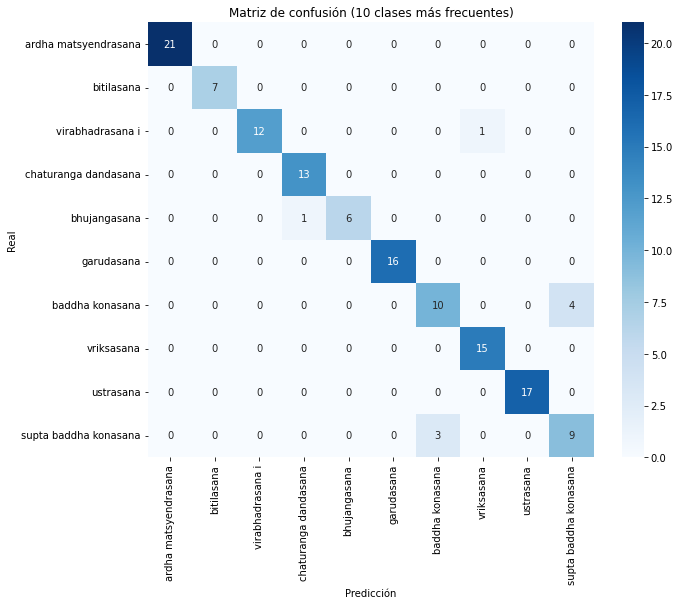

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
labels = rf.classes_

# Convertir a DataFrame para obtener totales
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Ordenar por las clases con más muestras (opcional)
top_labels = df_cm.sum(axis=1).sort_values(ascending=False).head(10).index  # 10 clases más comunes
df_cm_filtered = df_cm.loc[top_labels, top_labels]

# Dibujar matriz de confusión reducida
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm_filtered, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión (10 clases más frecuentes)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()